<a href="https://colab.research.google.com/github/susandong/w266_final_project_game_sentiment/blob/master/w266_Final_Project_Game_Review_Sentiment_Analysis_Aspect_Extraction_1116.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project: Game Review Sentiment Analysis Over Time
## Research Question: 
* Can we use sentiment analysis score to predict the active user base for video games over time

## Dataset: 
* Game Review: twitter/reddit/discord/steam reviews
* active user base: steam

## Algorithm: 
* Baseline(logistic Regression); 
* Transformer(Elmo/Bert)


In [1]:
#Load libraries
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
""" Download Data: There are 4 games with review data
Fall Guys (fg)
PlayerUnknown Battlegrounds (pubg)
Dota 2 (dota2)
Counterstrike Source: Go (csgo)

Review data has the following columns:
app: ID for the game
useful: how many users voted the review as useful
funny: how many users voted the review as funny
username: username of the person who wrote the review
games_owned: how many games the reviewer owns on Steam
num_reviews: how many reviews the reviewer has written on Steam
recommend: 1 for recommend (thumbs up), -1 for do not recommend (thumbs down)
hours_played: number of hours the reviewer played before writing the review
date: date review was written
text: text of the review
"""
#Fall Guys
fg_url = 'https://raw.githubusercontent.com/susandong/w266_final_project_game_sentiment/master/data/fallguys_reviews.csv'
fg_df = pd.read_csv(fg_url, error_bad_lines=False)
fg_df = fg_df.dropna()

#CS: Go
csgo_url = 'https://raw.githubusercontent.com/susandong/w266_final_project_game_sentiment/master/data/csgo_reviews.csv'
csgo_df = pd.read_csv(csgo_url, error_bad_lines=False)
csgo_df = csgo_df.dropna()

#PUBG
pubg_url = 'https://raw.githubusercontent.com/susandong/w266_final_project_game_sentiment/master/data/pubg_reviews.csv'
pubg_df = pd.read_csv(pubg_url, error_bad_lines=False)
pubg_df = pubg_df.dropna()

#dota2_url = 'https://raw.githubusercontent.com/susandong/w266_final_project_game_sentiment/master/data/dota2_reviews.csv'
#dota2_df = pd.read_csv(dota2_url, error_bad_lines=False)
#player_url = 'https://raw.githubusercontent.com/susandong/w266_final_project_game_sentiment/master/data/PlayerCountData.csv'
#player_df = pd.read_csv(player_url, error_bad_lines=False)

In [3]:
# Data Preprocessing
!pip install unidecode
import unidecode
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
#from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')

tknzr = TweetTokenizer()
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
#lemma = WordNetLemmatizer()

#Convert accented characters
def remove_accents(text):
  try:
    text = unidecode.unidecode(text)
  except:
    pass
  return text

#Remove digits and punctuation
def remove_nonletters(text):
  try:
    #Remove digits AND punctuation
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    #Remove just digits that are by themselves
    #text = re.sub('^\d+\s|\s\d+\s|\s\d+$', ' ', text)
  except:
    pass
  return text


#Use Tweet Tokenizer for some built-in emoji support
def tweet_tokenization(text):
  try:
    return tknzr.tokenize(text)
  except:
    pass

def remove_stopwords(token):
  try:
    return [item for item in token if item not in stop_words]
  except:
    pass

def remove_stemmer(token):
  try:
    return [stemmer.stem(i) for i in token]
  except:
    pass

def remove_lemmatizer(token):
  try:
    return [lemma.lemmatize(word=w, pow='v') for w in token]
  except:
    pass
  
def remove_shortwords(token):
  try:
    return [i for i in token if len(i) > 1]
  except:
    pass

def token_to_string(listTokens):
  return ' '.join(listTokens)

#Process text from dataframe. df = dataframe to clean, text = name of column with text
def process_text(df, text):  
  #Create new column for cleaned text
  df['cleaned'] = df[text]

  #Lower case all text
  df['cleaned'] = df['cleaned'].str.lower()

  #Clean URLs
  df['cleaned'] = df['cleaned'].str.replace('http\S+|www.\S+', '', case=False)

  #Remove accents from text
  #df['cleaned'] = df['cleaned'].apply(remove_accents)

  #Remove numbers and punctuation from text
  df['cleaned'] = df['cleaned'].apply(remove_nonletters)
  
  #Tokenize
  df['cleaned'] = df['cleaned'].apply(tweet_tokenization)

  #Remove stopwords
  #df['cleaned'] = df['cleaned'].apply(remove_stopwords)
  
  #Remove short words
  df['cleaned'] = df['cleaned'].apply(remove_shortwords)

  #Stemming - can decide to use or not
  #df['cleaned'] = df['cleaned'].apply(remove_stemmer)

  #Convert tokens back to string
  df['cleaned'] = df['cleaned'].apply(token_to_string)


     |████████████████████████████████| 245kB 4.2MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
#preprocess all the datasets for all 3 games
process_text(fg_df, 'text')
#len(fg_df['cleaned'][11]) < 2
process_text(csgo_df, 'text')
process_text(pubg_df, 'text')

In [5]:
fg_df

,app,useful,funny,username,games_owned,num_reviews,recommend,hours_played,date,text,cleaned
0,1097150,0,0,7.65612E+16,51,16,1,17.1,"11 October, 2020",ow i fell:( thats a sad face btwincase you did...,ow fell thats sad face btwincase you didnt kno...
1,1097150,0,0,7.65612E+16,1,1,1,50.4,"11 October, 2020",yes,yes
2,1097150,0,0,7.65612E+16,64,3,-1,8.1,"11 October, 2020",This Game is not fun. If your looking for a ga...,this game is not fun if your looking for game ...
3,1097150,0,0,floolp,1,1,1,15.3,"11 October, 2020",Fun but VERY HARD game!this is a very fun game...,fun but very hard game this is very fun game y...
4,1097150,0,0,7.65612E+16,6,1,1,34.9,"11 October, 2020",its fun,its fun
...,...,...,...,...,...,...,...,...,...,...,...
90653,1097150,3,0,7.65612E+16,0,1,-1,2.7,"8 September, 2020",A TOTAL GARBAGE!!i wish i never bought it and ...,total garbage wish never bought it and now wan...
90654,1097150,0,0,quazwaz,15,6,1,16.5,"8 September, 2020",this game is so simple my mom likes it 10/10,this game is so simple my mom likes it
90655,1097150,1,0,Elbourne,407,1,-1,18.7,"8 September, 2020","ruined by hackers and refused a refund, avoid.",ruined by hackers and refused refund avoid
90656,1097150,0,0,7.65612E+16,8,1,1,14.7,"8 September, 2020",very good game and fun to play,very good game and fun to play


In [6]:
from nltk.tokenize import RegexpTokenizer
def remove_blankrow(df,column):
  tokenizer = RegexpTokenizer(r'\w+')
  df['lens'] =[len(tokenizer.tokenize(utterance)) for utterance in df[column]]
  df_clean=df[df['lens'] !=0]
  return df_clean

In [7]:
#remove emoji 
def remove_emoji(df,column):
    df[column] = df[column].str.replace(r'[^\x00-\x7F]+', '')
    return df


In [8]:
#from google.colab import drive
#drive.mount('drive')
fg_df_text=remove_blankrow(fg_df,'cleaned')["cleaned"]

csgo_df_text=remove_blankrow(csgo_df,'cleaned')["cleaned"]
pubg_df_text=remove_blankrow(pubg_df,'cleaned')["cleaned"]
pubg_df_text.shape


(226783,)

In [9]:
## Aspect extraction EMbedding_gensim

In [49]:
list(fg_df_text)

['ow fell thats sad face btwincase you didnt kno whelp',
 'yes',
 'this game is not fun if your looking for game to frustrate and anger you with little reward or chance of winning this is prefect for you purchase to play with friends the party is always getting kicked the load times are terrible spent more time waiting to play than actually playing of the hours ve invested in the game maybe hours was actual gameplay',
 'fun but very hard game this is very fun game you should get it there is lots of character customization and you can look different to other players if you are known to rage at games then this game is not for you you will get very mad so be warned',
 'its fun',
 'sweet game',
 'good fun game nice to pick and play for short time',
 'very funn',
 'have played fall guys for hours now and it an amazing game from the maps to the interface of the game whats not to love about it would definitely recommend to anyone who wants fun interactive game to play',
 'thicc beanz',
 'it f

In [10]:


%matplotlib inline

import nltk.data;

from gensim.models import word2vec;

from sklearn.cluster import KMeans;
from sklearn.neighbors import KDTree;

import pandas as pd;
import numpy as np;

import os;
import re;
import logging;
import sqlite3;
import time;
import sys;
import multiprocessing;
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt;
from itertools import cycle;



In [11]:

nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle');



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [74]:
#tokenize text
fg_df_text_tokenized=fg_df_text.apply(tweet_tokenization)

In [77]:
start = time.time();

#Set the logging format to get some basic updates.
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 100;    # Dimensionality of the hidden layer representation
min_word_count = 4;   # Minimum word count to keep a word in the vocabulary
num_workers = multiprocessing.cpu_count();       # Number of threads to run in parallel set to total number of cpus.
context = 5          # Context window size (on each side)                                                       
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model. 
#The LineSentence object allows us to pass in a file name directly as input to Word2Vec,
#instead of having to read it into memory first.

print("Training model...");
model = word2vec.Word2Vec(fg_df_text_tokenized, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling);

# We don't plan on training the model any further, so calling 
# init_sims will make the model more memory efficient by normalizing the vectors in-place.
model.init_sims(replace=True);

# Save the model
model_name = "model_full_reddit";
model.save(model_name);

print('Total time: ' + str((time.time() - start)) + ' secs')

2020-11-15 07:50:03,524 : INFO : collecting all words and their counts
2020-11-15 07:50:03,525 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-11-15 07:50:03,577 : INFO : PROGRESS: at sentence #10000, processed 189986 words, keeping 10008 word types
2020-11-15 07:50:03,618 : INFO : PROGRESS: at sentence #20000, processed 352595 words, keeping 14872 word types
2020-11-15 07:50:03,657 : INFO : PROGRESS: at sentence #30000, processed 501734 words, keeping 18210 word types
2020-11-15 07:50:03,699 : INFO : PROGRESS: at sentence #40000, processed 664869 words, keeping 21477 word types


Training model...


2020-11-15 07:50:03,749 : INFO : PROGRESS: at sentence #50000, processed 850834 words, keeping 24443 word types
2020-11-15 07:50:03,806 : INFO : PROGRESS: at sentence #60000, processed 1059558 words, keeping 27216 word types
2020-11-15 07:50:03,874 : INFO : PROGRESS: at sentence #70000, processed 1344663 words, keeping 30210 word types
2020-11-15 07:50:03,938 : INFO : PROGRESS: at sentence #80000, processed 1603160 words, keeping 33061 word types
2020-11-15 07:50:03,981 : INFO : collected 34952 word types from a corpus of 1748803 raw words and 87847 sentences
2020-11-15 07:50:03,981 : INFO : Loading a fresh vocabulary
2020-11-15 07:50:04,009 : INFO : effective_min_count=4 retains 8887 unique words (25% of original 34952, drops 26065)
2020-11-15 07:50:04,010 : INFO : effective_min_count=4 leaves 1715203 word corpus (98% of original 1748803, drops 33600)
2020-11-15 07:50:04,041 : INFO : deleting the raw counts dictionary of 34952 items
2020-11-15 07:50:04,044 : INFO : sample=0.001 downsa

Total time: 13.486899137496948 secs


In [98]:
model = word2vec.Word2Vec.load('model_full_reddit')

2020-11-15 07:55:37,569 : INFO : loading Word2Vec object from model_full_reddit
2020-11-15 07:55:37,657 : INFO : loading wv recursively from model_full_reddit.wv.* with mmap=None
2020-11-15 07:55:37,658 : INFO : setting ignored attribute vectors_norm to None
2020-11-15 07:55:37,659 : INFO : loading vocabulary recursively from model_full_reddit.vocabulary.* with mmap=None
2020-11-15 07:55:37,659 : INFO : loading trainables recursively from model_full_reddit.trainables.* with mmap=None
2020-11-15 07:55:37,660 : INFO : setting ignored attribute cum_table to None
2020-11-15 07:55:37,661 : INFO : loaded model_full_reddit


In [100]:
model.wv['design']

array([ 0.0270799 , -0.07168573, -0.08829559,  0.13348192, -0.05361593,
       -0.00607436,  0.04072767, -0.00355269, -0.0685409 , -0.14180344,
        0.10414726, -0.06596999,  0.08392674,  0.00413413, -0.06025852,
       -0.0498799 , -0.07410289,  0.00292204, -0.02972949,  0.07912733,
       -0.03028378, -0.22373337, -0.16317497, -0.09884921,  0.00633425,
       -0.05285755,  0.12082996, -0.05382638,  0.16026105, -0.00714769,
        0.16048458,  0.20815495, -0.11708013, -0.16706963,  0.15888645,
       -0.16613878,  0.11135823, -0.05847164, -0.08171237, -0.05770887,
        0.13512626, -0.13833973,  0.11005305, -0.05325521, -0.01224408,
        0.01737359, -0.01534595,  0.0641663 ,  0.0613016 ,  0.13652706,
        0.1762791 ,  0.03376335, -0.1183256 , -0.13612773, -0.08002804,
       -0.20572528,  0.0980124 ,  0.23031296, -0.01632923, -0.08206062,
        0.11001215, -0.04870512, -0.19283043,  0.21150866, -0.05680741,
       -0.02379583, -0.1576282 , -0.10776325,  0.08362985, -0.04

In [101]:
Z = model.wv.syn0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [102]:
print([model.wv.index2word[i] for i in range(50)])

['the', 'game', 'and', 'to', 'it', 'fun', 'is', 'of', 'you', 'this', 'but', 'in', 'for', 'with', 'that', 'are', 'good', 'play', 'so', 'be', 'have', 'very', 'can', 'not', 'games', 'on', 'if', 'get', 'just', 'its', 'like', 'they', 'fall', 'or', 'there', 'as', 'friends', 'more', 'my', 'really', 'at', 'great', 'your', 'team', 'time', 'all', 'will', 'me', 'when', 'some']


In [82]:
print(Z[0].shape)
Z[0]

(100,)


array([ 2.55911112e-01, -2.04942711e-02, -7.89795816e-02,  3.09721362e-02,
        1.81912258e-02, -7.98699483e-02, -7.60681480e-02, -5.13617434e-02,
       -1.50052279e-01, -1.17195934e-01, -7.66689256e-02, -6.61655739e-02,
        7.97090232e-02,  1.75320968e-01,  9.96290706e-03, -4.06498015e-02,
        4.05232869e-02, -1.39060140e-01, -1.60567373e-01, -5.59492782e-02,
        6.54880926e-02,  1.15791909e-01, -4.36981767e-02, -3.14087123e-01,
        3.11867967e-02, -6.13002144e-02, -5.85354306e-02, -2.23112293e-02,
        1.79702997e-01,  4.29114439e-02, -9.44467559e-02, -3.80166024e-02,
       -1.86020173e-02,  1.17074721e-01, -1.33516952e-01, -1.30550444e-01,
       -1.03177287e-01, -2.20403410e-02,  6.03227876e-04,  3.14930044e-02,
        1.67958550e-02, -1.85108647e-01, -4.53839824e-02, -5.28661050e-02,
        2.14553475e-02, -2.34255046e-02, -7.04363436e-02,  1.53382421e-01,
        1.34013340e-01,  4.27373275e-02, -9.82455909e-03, -4.89716455e-02,
        1.86587811e-01,  

In [103]:


def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
    idx = kmeans_clustering.fit_predict(word_vectors);
    
    return kmeans_clustering.cluster_centers_, idx;



In [108]:
start = time.time();
centers, clusters = clustering_on_wordvecs(Z, 10);
print('Total time: ' + str((time.time() - start)) + ' secs')

Total time: 3.626905918121338 secs


In [109]:
start = time.time();
centroid_map = dict(zip(model.wv.index2word, clusters));
print('Total time: ' + str((time.time() - start)) + ' secs')

Total time: 0.006063699722290039 secs


In [110]:


def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);

    #Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];

    #Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i+1).zfill(2)] = [index2word[j] for j in closest_words_idxs[i][0]]

    #A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words);
    df.index = df.index+1

    return df;



In [111]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [112]:
top_words = get_top_words(model.wv.index2word, 30, centers, Z)

In [113]:
top_words

,Cluster #01,Cluster #02,Cluster #03,Cluster #04,Cluster #05,Cluster #06,Cluster #07,Cluster #08,Cluster #09,Cluster #10
1,tile,scammed,kiss,aesthetically,furthermore,mantap,appear,weekly,gentlemen,jogadores
2,directly,rick,arm,visually,dll,sranje,disconnected,generation,merda,bem
3,shoved,pickle,hero,cheerful,pata,igra,disconnect,textures,gravitationally,nunca
4,beam,lov,pants,brightly,spotty,nhu,finals,garry,mike,tanto
5,dodge,horses,daughters,wonderfully,oceanic,fune,immediately,interaction,tower,partida
6,hexagon,yee,teeth,bubbly,cac,bikin,qualified,unlockables,df,horas
7,hoop,freak,punched,whimsical,notably,fajna,banned,themes,sranje,divertir
8,walking,mantap,nephew,upbeat,temporarily,merda,later,clothing,stunden,modo
9,giant,pica,collective,playful,injection,cu,atleast,unlockable,doop,ta
10,foot,lik,lover,fantastically,west,szar,dc,tool,ovo,pasar


In [117]:
def get_word_table(table, key, sim_key='similarity', show_sim = True):
    if show_sim == True:
        return pd.DataFrame(table, columns=[key, sim_key])
    else:
        return pd.DataFrame(table, columns=[key, sim_key])[key]




2020-11-15 08:25:36,926 : INFO : precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [131]:
keys = ['game', 'design', 'tactic', 'money', 'time','character','feeling' ]
tables = []
for key in keys:
    tables.append(get_word_table(model.wv.similar_by_word(key), key, show_sim=False))
    

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [132]:
pd.concat(tables, axis=1)

,game,design,tactic,money,time,character,feeling
0,it,sound,selecting,moneys,day,avatar,satisfaction
1,experience,effects,mandatory,bucks,minute,opponents,crown
2,match,vibrant,coordination,dollars,minutes,body,rush
3,games,music,counts,purchase,round,legs,winning
4,day,catchy,removes,euros,match,blood,felt
5,fun,execution,renders,cash,session,skills,excitement
6,honestly,visuals,dreaded,euro,night,movement,accomplishment
7,however,artstyle,spectators,computer,times,characters,show
8,round,movement,talent,buying,haul,camera,secs
9,everything,art,carried,spending,start,head,feels


In [ ]:
#Aspect extraction of Game Reviews
##CAT: https://github.com/clips/cat

#not working

In [ ]:
#traditional 
#https://medium.com/@Intellica.AI/aspect-based-sentiment-analysis-everything-you-wanted-to-know-1be41572e238


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")
def extract_aspect(data):
    extracted_words =[]
    pos_tag=['NOUN']
    stop_words=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", 
            "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", 
            "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", 
            "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", 
            "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", 
            "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", 
            "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", 
            "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", 
            "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than",
            "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "yes"]

    for x in data[:,]:
      doc =nlp(x)
        #for np in doc.noun_chunks:
      #doc=[i.text for i in doc if i.text not in stop_words or i.text not in nlp.Defaults.stop_words and i.pos_=="NOUN"]
      #extracted_words.append(doc)
    #extracted_words=pd.Series(extracted_words)
    #extracted_words=extracted_words.value_counts().head(20).index.tolist() ## Get 5 most frequent nouns
    #return extracted_words
      for token in doc:
          if (token.text in nlp.Defaults.stop_words or token.text in stop_words):
              continue
          if (token.pos_ in pos_tag):
         #     #print(token.text)
         #         if token.text not in extracted_words:
              extracted_words.append(token.text)
    return extracted_words

In [ ]:
fg_df_text

0        ow fell thats sad face btwincase you didnt kno...
1                                                      yes
2        this game is not fun if your looking for game ...
3        fun but very hard game this is very fun game y...
4                                                  its fun
                               ...                        
90653    total garbage wish never bought it and now wan...
90654               this game is so simple my mom likes it
90655           ruined by hackers and refused refund avoid
90656                       very good game and fun to play
90657                                    bro it is amazing
Name: cleaned, Length: 87847, dtype: object

In [ ]:
extracted_noun=extract_aspect(fg_df_text)

In [ ]:
pd.Series(extracted_noun).value_counts()

game                                        66820
fun                                         17145
games                                        9853
friends                                      7304
team                                         6303
                                            ...  
supportsplitscreen                              1
disapearing                                     1
misplay                                         1
haccer                                          1
ssssssssssssssssssssssssssssssssssssssss        1
Length: 13259, dtype: int64

In [ ]:
unique_noun=pd.Series(extracted_noun).value_counts().head(200).index

In [ ]:
unique_noun

Index(['game', 'fun', 'games', 'friends', 'team', 'time', 'people', 'hackers',
       'guys', 'fall',
       ...
       'years', 'stage', 'glitches', 'lol', 'gaming', 'edit', 'mind', 'today',
       'genre', 'hack'],
      dtype='object', length=200)

In [ ]:
from gensim.models import Word2Vec

In [ ]:
from gensim.models import Word2Vec
  
from nltk.cluster import KMeansClusterer
import nltk
import numpy as np 
  
from sklearn import cluster
from sklearn import metrics
  
# training data
  
sentences = list(fg_df_text)
  
 
model = Word2Vec(sentences, min_count=1)
 
  
def sent_vectorizer(sent, model):
    sent_vec =[]
    numw = 0
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model[w]
            else:
                sent_vec = np.add(sent_vec, model[w])
            numw+=1
        except:
            pass
     
    return np.asarray(sent_vec) / numw
  
  
X=[]
for sentence in sentences:
    X.append(sent_vectorizer(sentence, model))   
 
print ("========================")
print (X)
 
 
  
 
# note with some version you would need use this (without wv) 
#  model[model.vocab] 
print (model[model.wv.vocab])
 
 
  
 
#print (model.similarity('post', 'book'))
#print (model.most_similar(positive=['machine'], negative=[], topn=2))
  
  
 
  
  
NUM_CLUSTERS=2
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
print (assigned_clusters)
  
  
  
for index, sentence in enumerate(sentences):    
    print (str(assigned_clusters[index]) + ":" + str(sentence))
 
     
     
     
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)
  
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
  
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
  
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
  
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
  
print ("Silhouette_score: ")
print (silhouette_score)
 
 
import matplotlib.pyplot as plt
 
from sklearn.manifold import TSNE
 
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
 
Y=model.fit_transform(X)
 

plt.scatter(Y[:, 0], Y[:, 1], c=assigned_clusters, s=290,alpha=.5)
 
 
for j in range(len(sentences)):    
   plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords='offset points')
   print ("%s %s" % (assigned_clusters[j],  sentences[j]))
 
 
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [ ]:
word2vec = spacy.load('en_core_web_sm')
word_vec = [word2vec(i).vector for i in unique_noun]

In [ ]:
word_vec_new=np.array(word_vec)

In [ ]:
word_vec_new.shape

(200, 96)

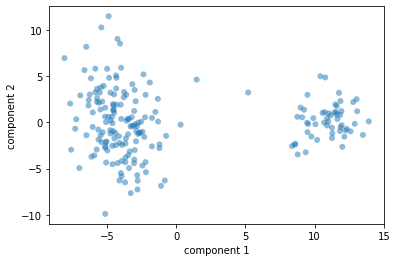

In [ ]:
from sklearn.decomposition import PCA
#use PCA to reduce dimensions to 2
from matplotlib.colors import ListedColormap

def P2():
    pca = PCA(n_components = 2)
    pca.fit(word_vec_new)
    train_pca = pca.transform(word_vec_new)
    
    plt.scatter(train_pca[:, 0], train_pca[:, 1],
             edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdBu_r', 10))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    return train_pca

train_pca =P2()



In [ ]:
def plot_clusters(data, algorithm, args, kwds):
   
    labels = algorithm(*args, **kwds).fit_predict(data)
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)))
    

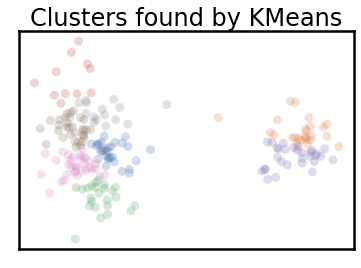

In [ ]:
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
import matplotlib.pyplot as plt
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

#plot_clusters(train_pca, cluster.AgglomerativeClustering, (), {'n_clusters':10, 'linkage':'ward'})
plot_clusters(train_pca, KMeans, (), {'n_clusters':8})

In [ ]:
def computeBIC (clstrs, X):
    n = X.shape[1]
    m = X.shape[0]
    k = len(clstrs.cluster_centers_)
    Dw = np.power(clstrs.inertia_, 2)
    Db = 0
    for cc0 in range (k):
        for cc1 in range (k):
            if not cc0 == cc1:
                Db = Db + distance.euclidean (clstrs.cluster_centers_[cc0], clstrs.cluster_centers_[cc1])
    ## print("Dw = %.3f; Db = %.3f" %(Dw,Db))
    D = np.sqrt (Dw + np.power(Db, 2))
    BIC = D + np.log(n)*m*k
    AIC = D + 2*m*k    
    return BIC, AIC


In [ ]:
from scipy.spatial import distance
n_clusters = range(1,20)
for n in n_clusters:
    km = KMeans (n_clusters=n, init='k-means++')
    clstrs = km.fit (train_pca)
    bic, aic = computeBIC(clstrs,train_pca)
    print("Number of clusters = %d.  BIC = %.3f. AIC = %.3f" % (n, bic, aic))

Number of clusters = 1.  BIC = 11839.874. AIC = 12101.244
Number of clusters = 2.  BIC = 3015.146. AIC = 3537.887
Number of clusters = 3.  BIC = 1860.017. AIC = 2644.128
Number of clusters = 4.  BIC = 1657.108. AIC = 2702.590
Number of clusters = 5.  BIC = 1627.927. AIC = 2934.780
Number of clusters = 6.  BIC = 1674.334. AIC = 3242.558
Number of clusters = 7.  BIC = 1779.653. AIC = 3609.246
Number of clusters = 8.  BIC = 1926.321. AIC = 4017.286
Number of clusters = 9.  BIC = 2179.481. AIC = 4531.816
Number of clusters = 10.  BIC = 2488.832. AIC = 5102.537
Number of clusters = 11.  BIC = 2741.173. AIC = 5616.249
Number of clusters = 12.  BIC = 3066.530. AIC = 6202.977
Number of clusters = 13.  BIC = 3463.550. AIC = 6861.368
Number of clusters = 14.  BIC = 3817.583. AIC = 7476.771
Number of clusters = 15.  BIC = 4230.167. AIC = 8150.725
Number of clusters = 16.  BIC = 4698.782. AIC = 8880.711
Number of clusters = 17.  BIC = 5261.519. AIC = 9704.819
Number of clusters = 18.  BIC = 5546.2

In [ ]:
from sklearn.cluster import KMeans

def cluster_generate(model,data,kwds):
    model = model(**kwds)
    #print(model)
    y_model= model.fit_predict(data)
    #print(y_model)

    utterance_vec_list = pd.DataFrame({'utterance_text':unique_noun,'vector':list(word_vec_new)},columns = ['utterance_text','vector'])
  
    utterance_vec_list['cluster'] =y_model
  
    utterance_cluster = utterance_vec_list.drop('vector', axis =1)

    data_cluster = pd.DataFrame(data, columns = ['x','y'])

    data_cluster['cluster']=y_model
    facet = sns.lmplot(data=data_cluster, x='x', y='y', hue='cluster', 
                 fit_reg=False, legend=False, size =10)
    leg = facet.ax.legend(bbox_to_anchor=[1, 1 ],loc ='upper left',ncol=5,
                        title="cluster", fancybox=False)
    plt.show()
    counts =list(utterance_vec_list.groupby(['cluster'])['utterance_text'].count())
    for i in range(clusters):
        print("Cluster %2d with %2d observations" %(i,counts[i]))
    #list utterances by clusters
    cluster_detail=pd.DataFrame()
    for j in range(clusters):
        if counts[j] >0:
            cluster_detail_1=pd.DataFrame()
            cluster_detail_1 = utterance_cluster.groupby(['cluster']).get_group(j)
            print(cluster_detail_1)
            cluster_detail=pd.concat([cluster_detail,cluster_detail_1])
    #print(cluster_detail)
    return cluster_detail

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


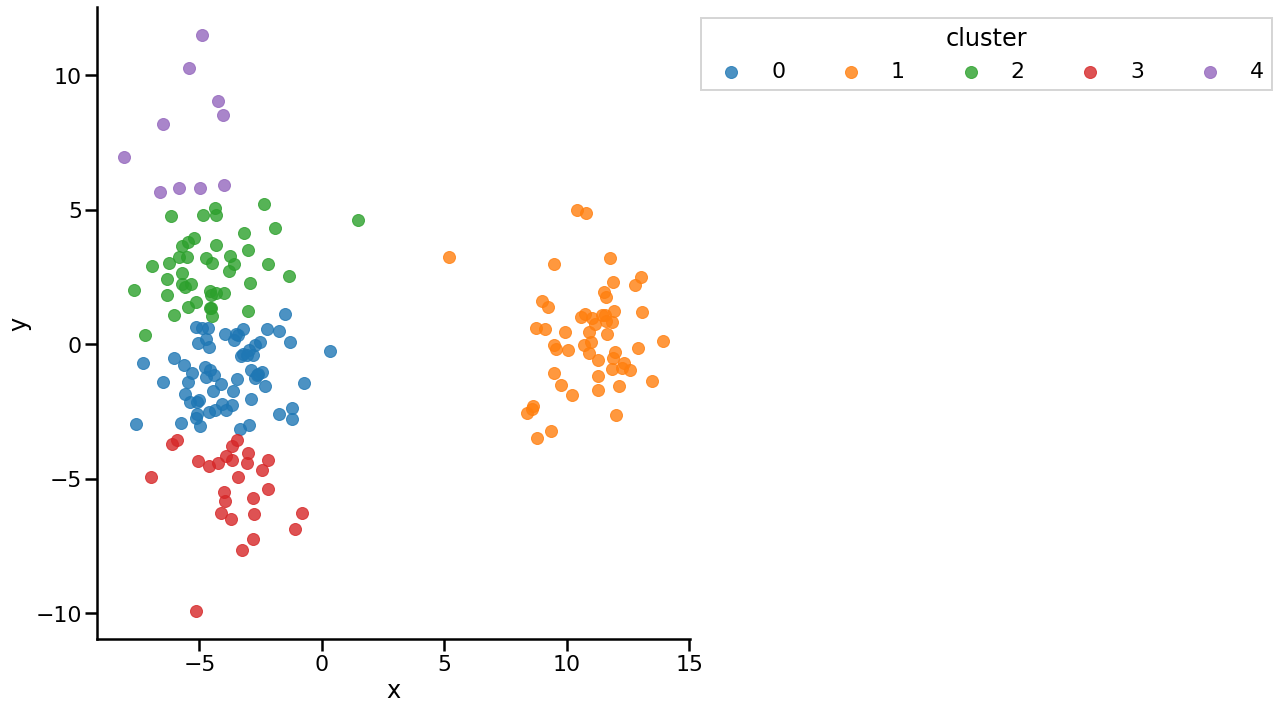

Cluster  0 with 64 observations
Cluster  1 with 55 observations
Cluster  2 with 44 observations
Cluster  3 with 27 observations
Cluster  4 with 10 observations
    utterance_text  cluster
14          server        0
18          battle        0
23            tail        0
25           round        0
30         problem        0
..             ...      ...
186           shop        0
188        garbage        0
191          stage        0
196           mind        0
198          genre        0

[64 rows x 2 columns]
    utterance_text  cluster
2            games        1
3          friends        1
6           people        1
7          hackers        1
8             guys        1
10        cheaters        1
11         servers        1
12         players        1
15          issues        1
16           hours        1
17            maps        1
20           times        1
24            devs        1
26           modes        1
34          levels        1
37       minigames        1
45   

In [ ]:
clusters=5
cluster_detail_3 =cluster_generate(KMeans,train_pca,{'n_clusters':5})


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words="english")
tf = vectorizer.fit_transform(fg_df_text) # apply transformation
tf_feature_names = vectorizer.get_feature_names()#tf_feature_names tells us what word each column in the matric represents
tf.shape


(87847, 34653)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
number_of_topics = 15
model = LatentDirichletAllocation(n_components=number_of_topics, random_state=45) # random state for reproducibility# Fit data to model
LDA = model.fit(tf)

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
n_top_words = 10

In [ ]:
print("\nTopics in LDA model with CountVectorizer:")
tf_feature_names
print_top_words(LDA, tf_feature_names, n_top_words)


Topics in LDA model with CountVectorizer:
Topic #0: good game soy awesome boy bad just bugs kids grind
Topic #1: fall guys falling lit gg like ultimate help men gang
Topic #2: game best epic like gud big year simulator cute makes
Topic #3: funny addicting game chill fortnite yeah que haha better jogo
Topic #4: game games players like playing time fun just way don
Topic #5: love amazing game battle royale bean beans party jelly mario
Topic #6: game fun play like maps really just friends new add
Topic #7: game server issues fun castle day takeshi great launch servers
Topic #8: fun game play friends really nice great super recommend just
Topic #9: cool pretty pog game xd op guess juego tho lmao
Topic #10: game yes great played buy time hours worth ve playing
Topic #11: game hackers cheaters hacker cheater win fix lol report problem
Topic #12: team games game tail just like grab people based luck
Topic #13: game play servers time just server fun worth fix money
Topic #14: fall guy people 

In [ ]:
#use TfidfVectorizer and LDA
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer(stop_words="english")
tf2 = vectorizer_tfidf.fit_transform(csgo_df_text) # apply transformation
tf_feature_names_2 = vectorizer_tfidf.get_feature_names()#tf_feature_names tells us what word each column in the matric represents
tf.shape



(87847, 34653)

In [ ]:
model_LDA = LatentDirichletAllocation(n_components=number_of_topics, random_state=45) # random state for reproducibility# Fit data to model
LDA_fit = model.fit(tf2)

In [ ]:
print("\nTopics in LDA model with tfidf vectorizer:")
tf_feature_names_2
print_top_words(LDA_fit, tf_feature_names_2, n_top_words)


Topics in LDA model with tfidf vectorizer:
Topic #0: ok guess hours lit game yeet gut old played cheat
Topic #1: game cheaters play good prime hackers fun lot just playing
Topic #2: good game love okay valorant better pog hack sexy hacks
Topic #3: best game fps amazing epic games shooter played world competitive
Topic #4: yes noice rush meh funny eh poop kinda goood solid
Topic #5: toxic just community yeah game suck bruh oct people time
Topic #6: great game really enjoy guud fine hvh stuff overall good
Topic #7: cool gg sucks game recommend addictive da silver try broken
Topic #8: nice game hackers alright cs blyat cyka ye perfect gaem
Topic #9: trash lol csgo aight god counter strike game lots skins
Topic #10: pew game russian decent dont competitive easy learn kill play
Topic #11: bad classic game sick gun alot mad im knife poggers
Topic #12: like ez russians game super die garbage lmao nais gaben
Topic #13: gud xd hate gay game veri wow cancer gam dope
Topic #14: fun game play pre

In [ ]:
#labels: game, design, tactic, time, money